# Animation

This is a tutorial to create a sliding scale animation that allows you to look at a range of images in order. As always, start with the necessary imports:

In [1]:
import chromatic_extracting
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from IPython.display import display
import ipywidgets as widgets
from datetime import datetime

Direct the code to the path where the fits files are stored. My path is as follows:

In [2]:
# Directory containing FITS files
fits_directory = '/Users/zashaavery/Documents/WASP-94A_fits/ut140801'

Next, the files need to be sorted in the order in which they were taken. This will ensure that the transit is seen correctly.

In [3]:
# Create a list to store (filename, observation_datetime) tuples
obs_list = []

# Iterate over all FITS files in the directory
for filename in os.listdir(fits_directory):
    if filename.endswith('.fits'):
        fits_file = os.path.join(fits_directory, filename)
        
        # Open the FITS file and extract observation date and time
        with fits.open(fits_file) as hdul:
            date_obs = hdul[0].header.get('DATE-OBS', None)
            time_obs = hdul[0].header.get('TIME-OBS', None)
            
            object_obs = hdul[0].header.get('OBJECT', None)
            exposure = hdul[0].header.get('EXPTIME', None)
            airmass = hdul[0].header.get('AIRMASS', None)
            RA = hdul[0].header.get('RA', None)
            DEC = hdul[0].header.get('DEC', None)
            
            if date_obs and time_obs:
                obs_datetime_str = f"{date_obs} {time_obs}"
                obs_datetime = datetime.strptime(obs_datetime_str, '%Y-%m-%d %H:%M:%S.%f')
                obs_list.append((filename, obs_datetime, object_obs, exposure, airmass, RA, DEC))

# Sort the obs_list based on observation datetime
sorted_obs_list = sorted(obs_list, key=lambda x: x[1])

# Print the sorted list. Only print to check if sorting works. 
#for filename, obs_datetime in sorted_obs_list:
#    print(f"Filename: {filename}, Observation Time: {obs_datetime}, object: {object_obs}")

Sort the images as well.

In [7]:
# Create a list to store the images in sorted order
sorted_filename_list = []
sorted_object_list = []
sorted_exposure_list = []
sorted_airmass_list = []
sorted_RA_list = []
sorted_DEC_list = []
sorted_image_list = []

# Load the image data for each observation in sorted order
for filename, obs_datetime, object_obs, exposure, airmass, RA, DEC in sorted_obs_list:
    sorted_filename_list.append(filename)
    sorted_object_list.append(object_obs)
    sorted_exposure_list.append(exposure)
    sorted_airmass_list.append(airmass)
    sorted_RA_list.append(RA)
    sorted_DEC_list.append(DEC)
    fits_file = os.path.join(fits_directory, filename)
    image_data = fits.getdata(fits_file, ext=0)
    sorted_image_list.append(image_data)

The last step is to create the figure which allows the user to filter through the images. vmin and vmax are available as sliders as well and allow the color of the image to change so features can be seen more clearly. In addition, the cmap can be changed to other colormaps. 
There is also diagnostic information shown to the right of the image. Currently, the diagnostic information shown is:

FILENAME 
OBJECT
EXPTIME
AIRMASS
RA
DEC

but more information can be added.

<IPython.core.display.Javascript object>


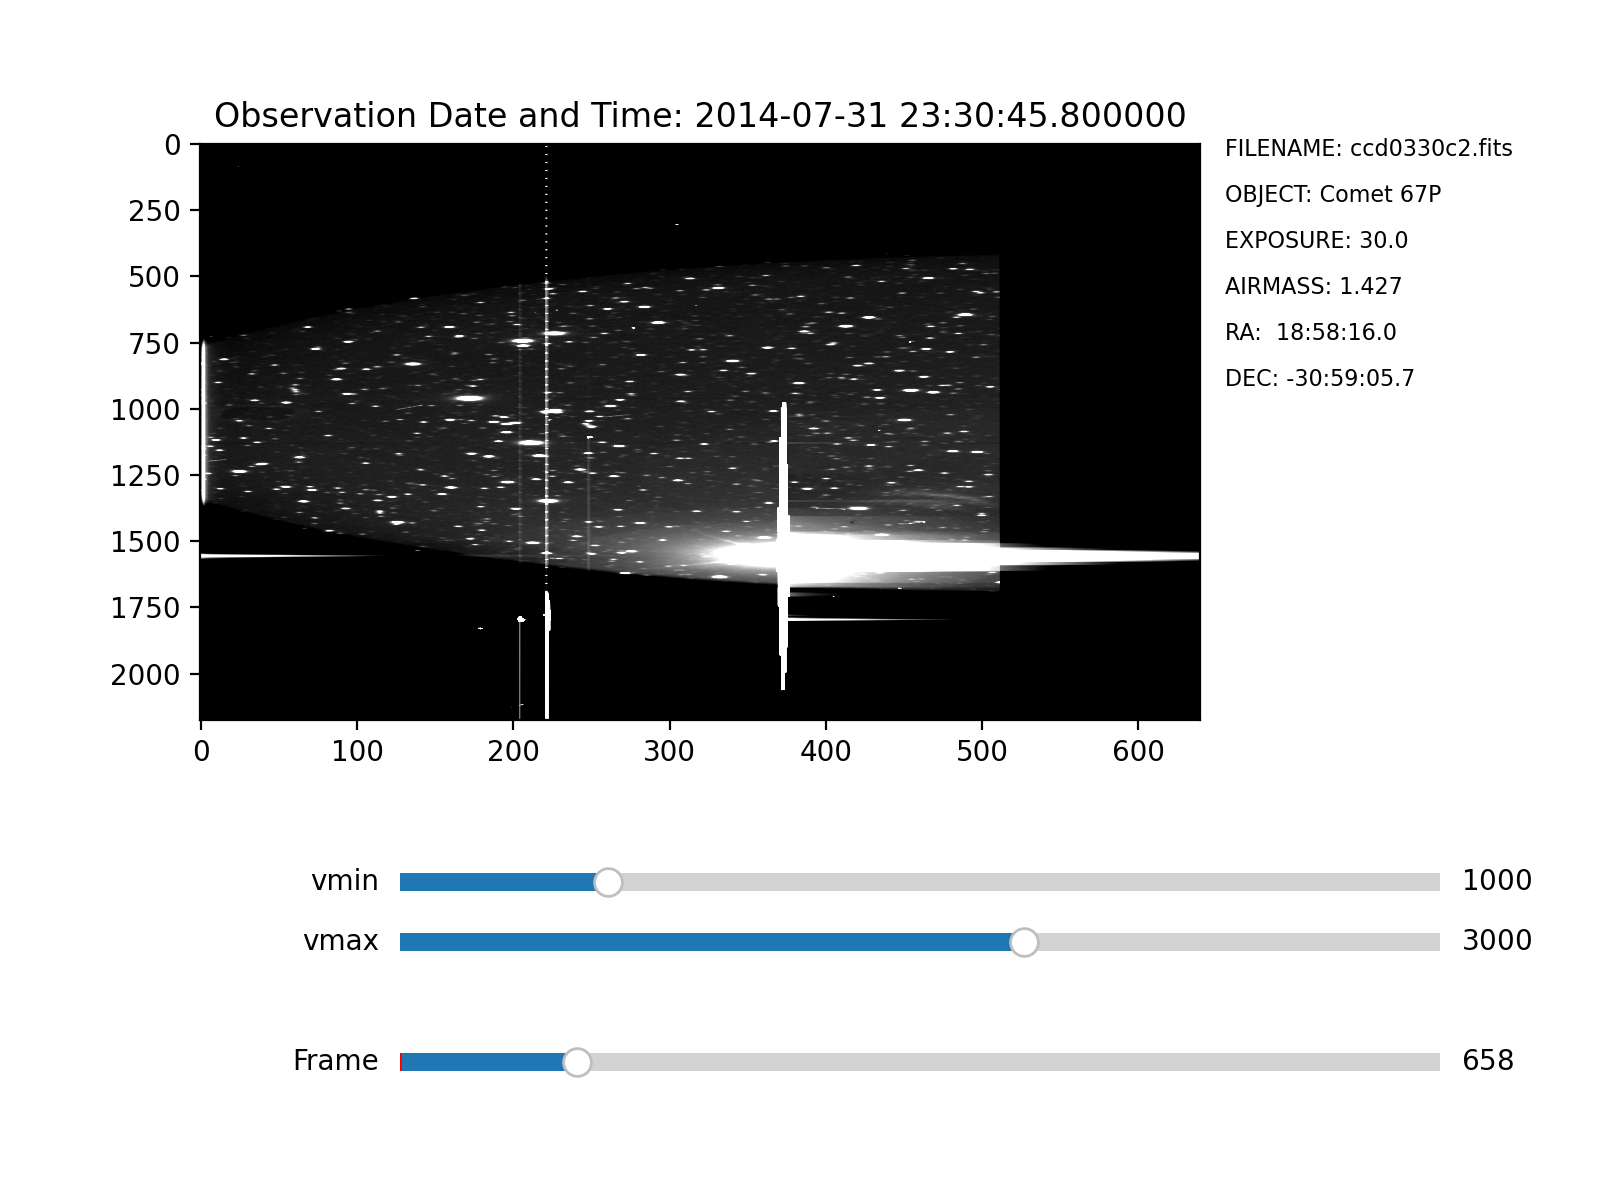

In [14]:
# Set the display backend to support interactive figures
%matplotlib notebook

# Initialize figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
plt.subplots_adjust(bottom=0.4) #Adjust to account for sliders
plt.subplots_adjust(right=0.75) #Adjust to account for diagnostic information

# Display the first image
current_frame = 0

# Initial values for vmin and vmax
initial_vmin = 1000
initial_vmax = 3000

# Apply a colormap (cmap) and control the strength using vmin and vmax
im = ax.imshow(sorted_image_list[current_frame], cmap='gray', vmin=initial_vmin, vmax=initial_vmax, aspect='auto')

object_obs = sorted_obs_list[current_frame][2]
title = ax.set_title(f"Observation Date and Time: {obs_datetime}")

file_name = fig.text(1.025, 0.98, f"FILENAME: {filename}", transform = ax.transAxes, fontsize = 8)
object_name = fig.text(1.025, 0.9, f"OBJECT: {object_obs}", transform = ax.transAxes, fontsize = 8)
exposure_name = fig.text(1.025, 0.82, f"EXPOSURE: {exposure}", transform = ax.transAxes, fontsize = 8)
airmass_name = fig.text(1.025, 0.74, f"AIRMASS: {airmass}", transform = ax.transAxes, fontsize = 8)
RA_name = fig.text(1.025, 0.66, f"RA: {RA}", transform = ax.transAxes, fontsize = 8)
DEC_name = fig.text(1.025, 0.58, f"DEC: {DEC}", transform = ax.transAxes, fontsize = 8)

# Create sliders for vmin and vmax. Keep in mind, vmin < vmax
ax_slider_vmin = plt.axes([0.25, 0.25, 0.65, 0.03])
slider_vmin = Slider(ax_slider_vmin, 'vmin', 0, 5000, valinit=initial_vmin, valstep=1)

ax_slider_vmax = plt.axes([0.25, 0.2, 0.65, 0.03])
slider_vmax = Slider(ax_slider_vmax, 'vmax', 0, 5000, valinit=initial_vmax, valstep=1)

# Function to update the displayed image
def update(val):
    global current_frame
    current_frame = int(slider_frame.val)
    obs_datetime = sorted_obs_list[current_frame][1]
    title.set_text(f"Observation Date and Time: {obs_datetime}")
    
    # Get the filename for the current frame
    filename = sorted_filename_list[current_frame]
    file_name.set_text(f"FILENAME: {filename}")
    
    object_obs = sorted_object_list[current_frame]
    object_name.set_text(f"OBJECT: {object_obs}")
    
    exposure = sorted_exposure_list[current_frame]
    exposure_name.set_text(f"EXPOSURE: {exposure}")
    
    airmass = sorted_airmass_list[current_frame]
    airmass_name.set_text(f"AIRMASS: {airmass}")
    
    RA = sorted_RA_list[current_frame]
    RA_name.set_text(f"RA: {RA}")
    
    DEC = sorted_DEC_list[current_frame]
    DEC_name.set_text(f"DEC: {DEC}")
    
    # Update the image data using the selected colormap and strength
    im.set_data(sorted_image_list[current_frame])
    
    # Update colormap limits using the vmin and vmax sliders
    im.set_clim(vmin=slider_vmin.val, vmax=slider_vmax.val)
    
    fig.canvas.draw_idle()

# Connect the vmin and vmax sliders to the update function
slider_vmin.on_changed(update)
slider_vmax.on_changed(update)

# Create a slider for navigation
ax_slider_frame = plt.axes([0.25, 0.1, 0.65, 0.03])
slider_frame = Slider(ax_slider_frame, 'Frame', 0, len(sorted_image_list) - 1, valinit=current_frame, valstep=1)

# Function to update the displayed frame
def update_frame(val):
    global current_frame
    current_frame = int(slider_frame.val)
    obs_datetime = sorted_obs_list[current_frame][1]
    title.set_text(f"Observation Date and Time: {obs_datetime}")
    
    # Get the filename for the current frame
    filename = sorted_filename_list[current_frame]
    file_name.set_text(f"FILENAME: {filename}")
    
    object_obs = sorted_object_list[current_frame]
    object_name.set_text(f"OBJECT: {object_obs}")
    
    exposure = sorted_exposure_list[current_frame]
    exposure_name.set_text(f"EXPOSURE: {exposure}")
    
    airmass = sorted_airmass_list[current_frame]
    airmass_name.set_text(f"AIRMASS: {airmass}")
    
    RA = sorted_RA_list[current_frame]
    RA_name.set_text(f"RA: {RA}")
    
    DEC = sorted_DEC_list[current_frame]
    DEC_name.set_text(f"DEC: {DEC}")
    
    im.set_data(sorted_image_list[current_frame])
    fig.canvas.draw_idle()
    
    
    
# Connect the frame slider to its update function
slider_frame.on_changed(update_frame)

# Display the interactive figure
plt.show()
